<a href="https://colab.research.google.com/github/yesiltepe-hidir/NVAE/blob/master/NRAE_MNIST_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yesiltepe-hidir/NVAE.git
!pip install tensorboardX

Cloning into 'NVAE'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 197 (delta 74), reused 88 (delta 50), pack-reused 70
Receiving objects: 100% (197/197), 13.41 MiB | 36.53 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 25.9 MB/s 


In [1]:
%cd NRAE

/content/NRAE


In [2]:
!python3 train.py --dataset mnist --epochs 100 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax

Experiment dir : /content/NRAE/eval-
starting in debug mode
100% 9912422/9912422 [00:00<00:00, 115568342.58it/s]
Extracting /content/NRAE/MNIST/raw/train-images-idx3-ubyte.gz to /content/NRAE/MNIST/raw

100% 28881/28881 [00:00<00:00, 121622182.55it/s]
Extracting /content/NRAE/MNIST/raw/train-labels-idx1-ubyte.gz to /content/NRAE/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 164480019.90it/s]
Extracting /content/NRAE/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/NRAE/MNIST/raw

100% 4542/4542 [00:00<00:00, 25989807.32it/s]
Extracting /content/NRAE/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/NRAE/MNIST/raw

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker 

# Preprocess

In [3]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn import mixture
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets
from thirdparty.lsun import LSUN
from torchvision import transforms
import torchvision.datasets as dset

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt


# Get args
PATH = '/content/NRAE/eval-/checkpoint.pt'
checkpoint_nrae = torch.load(PATH)

# Get args
args_rae = checkpoint_nrae['args']

# Create Model
writer = utils.Writer(args_rae.global_rank, args_rae.save)
arch_instance = utils.get_arch_cells(args_rae.arch_instance)
model_nrae = AutoEncoder(args_rae, writer, arch_instance)
model_nrae = model_nrae.cuda()

# Load Model
model_nrae.load_state_dict(checkpoint_nrae['state_dict'])

# Get z0
z0_nrae = checkpoint_nrae['z0']

# Get logits
logits_nrae = checkpoint_nrae['logits']
logits_nrae.size()

model_nrae.eval()
model_nrae.training

# Initialize
os.environ['MASTER_ADDR'] = args_rae.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args_rae.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args_rae.num_process_per_node)

def _data_transforms_lsun(size):
    train_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    valid_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ])

    return train_transform, valid_transform


def _data_transforms_mnist(args):
    """Get data transforms for cifar10."""
    train_transform = transforms.Compose([
        transforms.Pad(padding=2),
        transforms.ToTensor(),
        # Binarize(),
    ])

    valid_transform = transforms.Compose([
        transforms.Pad(padding=2),
        transforms.ToTensor(),
        # Binarize(),
    ])

    return train_transform, valid_transform

# from thirdparty.lsun import LSUN
# from torchvision import transforms

# # Preprocess data
# resize = 64
# num_classes = 1
# _, valid_transform = _data_transforms_lsun(resize)
# valid_data = LSUN(root='/content/NRAE', classes=['church_outdoor_val'], transform=valid_transform)
args_rae.data = '/content/NRAE'
num_classes = 10
train_transform, valid_transform = _data_transforms_mnist(args_rae)
train_data = dset.MNIST(
    root=args_rae.data, train=True, download=False, transform=train_transform)
valid_data = dset.MNIST(
    root=args_rae.data, train=False, download=False, transform=valid_transform)


train_sampler, valid_sampler = None, None

if args_rae.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)
    valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_data)

train_queue = torch.utils.data.DataLoader(
        train_data, batch_size=args_rae.batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler, pin_memory=True, num_workers=8, drop_last=True)

valid_queue = torch.utils.data.DataLoader(
    valid_data, batch_size=args_rae.batch_size,
    shuffle=(valid_sampler is None),
    sampler=valid_sampler, pin_memory=True, num_workers=1, drop_last=False)

MULT:  1.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Qualitative Results

In [4]:
def fit(model, queue, gmm):
  z = []
  with torch.no_grad():
    for num, x in enumerate(queue):
      x = x[0].float().cuda()

      # Normalize x between -1, 1       
      s = model.stem(2*x-1)     
      
      # perform pre-processing         
      for cell in model.pre_process:   
          s = cell(s)                  
                                      
      # run the main encoder tower
      for cell in model.enc_tower:    
        if cell.cell_type != 'combiner_enc':
            s = cell(s)

      idx_dec = 0
      ftr = model.enc0(s)             
      z_ = model.enc_sampler[idx_dec](ftr) 
      z.append(z_)

  
  z = torch.cat(z)
  print('z:', z.shape)
  z = z.view(z.size(0), -1)
  gmm.fit(z.cpu().detach())
  
  return gmm, z

In [5]:
def sample(model, gmm, num_samples, z0=None):
  with torch.no_grad():
    scale_ind = 0
    
    z = z0  if z0 is not None else torch.tensor(gmm.sample(num_samples)[0]).view(num_samples, 1, 8, 8).cuda().float()
    z0_ret = z

    idx_dec = 0
    s = model.prior_ftr0.unsqueeze(0)
    batch_size = z.size(0)
    s = s.expand(batch_size, -1, -1, -1)
    for cell in model.dec_tower:
        if cell.cell_type == 'combiner_dec':
            if idx_dec > 0:
                # form prior
                z = model.dec_sampler[idx_dec - 1](s)
                # mu, log_sigma = torch.chunk(param, 2, dim=1)
                # dist = Normal(mu, log_sigma, t)
                # z, _ = dist.sample()

            # 'combiner_dec'
            s = cell(s, z)
            idx_dec += 1
        else:
            s = cell(s)
            if cell.cell_type == 'up_dec':
                scale_ind += 1

    for cell in model.post_process:
        s = cell(s)

    logits = model.image_conditional(s)
  return logits, z0_ret

In [6]:
def visualize(n_samples, model, logits, title='', offset=0, size=(8, 8)):
  output = logits[offset:offset + n_samples]
  output_img = output
  output_tiled = utils.tile_image(output_img, int(n_samples ** 0.5)).squeeze(0).float()
  
  plt.rcParams["figure.figsize"] = size
  plt.axis('off')
  plt.imshow(output_tiled.detach().cpu().numpy(),cmap='gray')
  

In [8]:
gmm = mixture.GaussianMixture(
            n_components=10,
            covariance_type="full",
            max_iter=2000,
            verbose=2,
            tol=1e-3,
        )

In [9]:
gmm, z_enc = fit(model_nrae, train_queue, gmm)

z: torch.Size([60000, 1, 8, 8])
Initialization 0
  Iteration 10	 time lapse 10.77416s	 ll change 0.12946
  Iteration 20	 time lapse 9.68239s	 ll change 0.00614
  Iteration 30	 time lapse 9.74385s	 ll change 0.00441
  Iteration 40	 time lapse 9.76948s	 ll change 0.00236
  Iteration 50	 time lapse 10.82258s	 ll change 0.00163
Initialization converged: True	 time lapse 53.67282s	 ll 28.40667


In [13]:
n_components = 10
gmm_drichlet = mixture.BayesianGaussianMixture(n_components=n_components, covariance_type='full',
                                                         weight_concentration_prior=1.0/n_components)

In [14]:
gmm_drichlet, z_enc = fit(model_nrae, train_queue, gmm_drichlet)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


z: torch.Size([60000, 1, 8, 8])


/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


# Samples

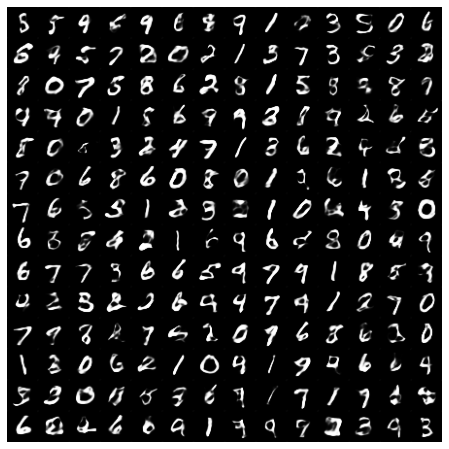

In [15]:
# Drichlet
# !python3 train.py --dataset mnist --epochs 100 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 196
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


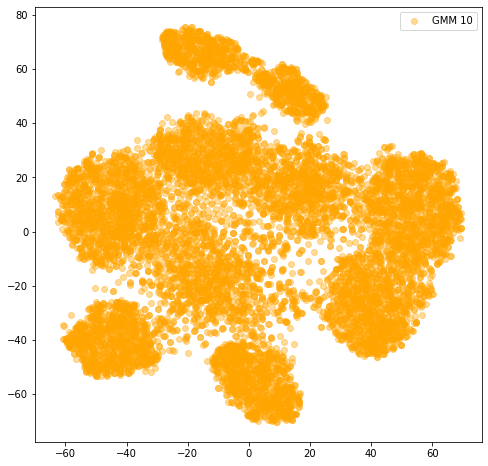

In [17]:
num_samples = 10000
xpde = gmm_drichlet.sample(num_samples)[0]
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(xpde)
plt.rcParams["figure.figsize"] = (8, 8)
# plt.axis('off')
plt.scatter(latent[:, 0], latent[:, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

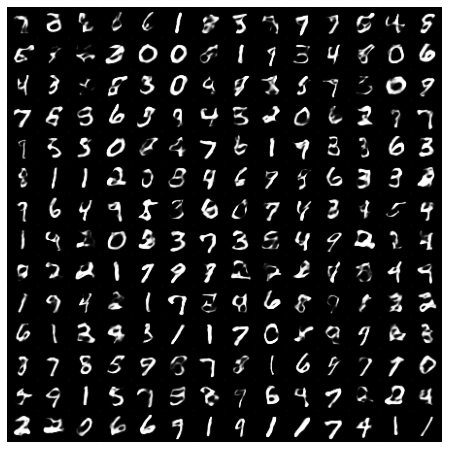

In [11]:
# GMM 10
# !python3 train.py --dataset mnist --epochs 100 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 196
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


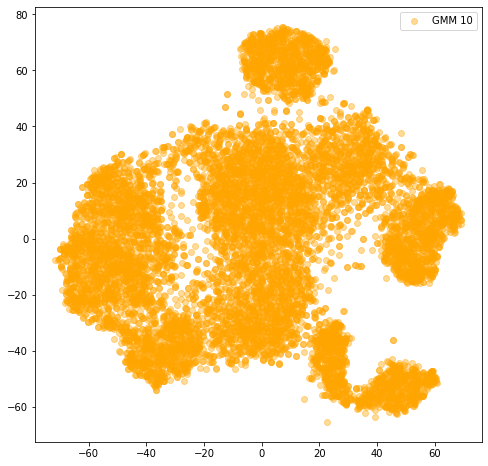

In [16]:
num_samples = 10000
xpde = gmm.sample(num_samples)[0]
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(xpde)
plt.rcParams["figure.figsize"] = (8, 8)
# plt.axis('off')
plt.scatter(latent[:, 0], latent[:, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

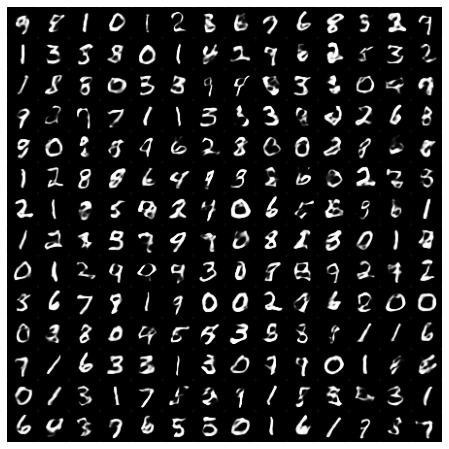

In [ ]:
# GMM Drichlet
# !python3 train.py --dataset mnist --epochs 50 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 196
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


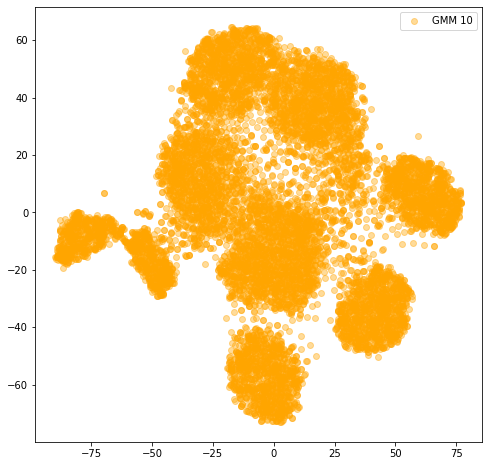

In [ ]:
num_samples = 10000
xpde = gmm_drichlet.sample(num_samples)[0]
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(xpde)
plt.rcParams["figure.figsize"] = (8, 8)
# plt.axis('off')
plt.scatter(latent[:, 0], latent[:, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

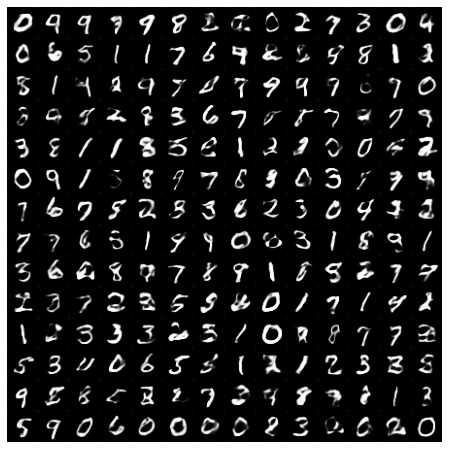

In [ ]:
# GMM 10
# !python3 train.py --dataset mnist --epochs 50 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 196
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


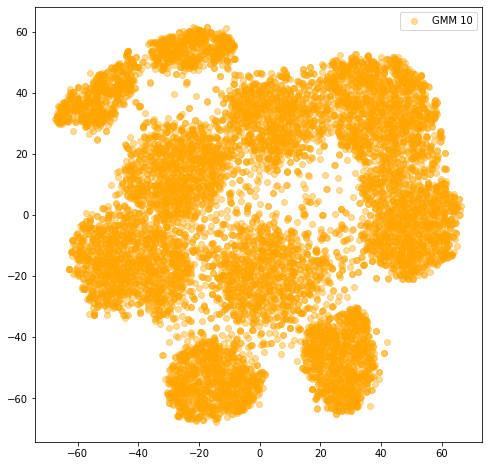

In [ ]:
num_samples = 10000
xpde = gmm.sample(num_samples)[0]
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(xpde)
plt.rcParams["figure.figsize"] = (8, 8)
# plt.axis('off')
plt.scatter(latent[:, 0], latent[:, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

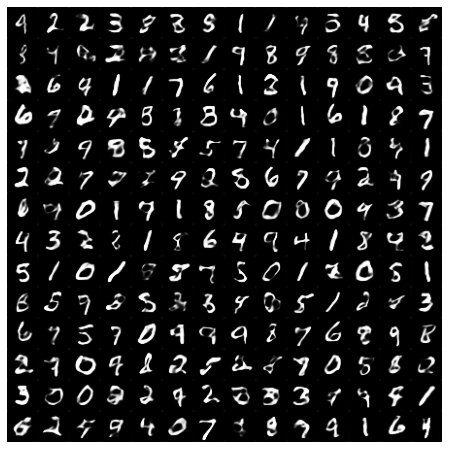

In [ ]:
# GMM 10
# !python3 train.py --dataset mnist --epochs 50 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 196
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

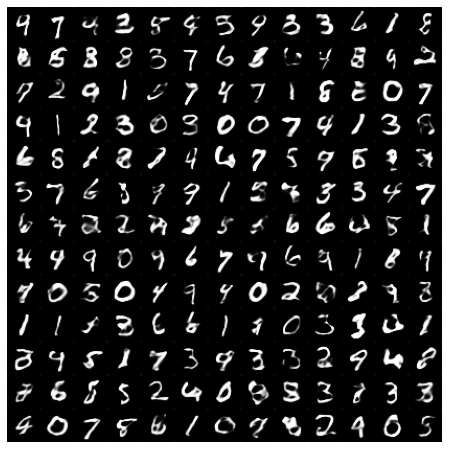

In [ ]:
#!python3 train.py --dataset mnist --epochs 50 --root /content/NRAE  --data /content/NRAE --save /eval- --batch_size 200 --learning_rate 1e-4 --l2_weight 1000 --embedding_weight 1e-4 --num_latent_per_group 1 --fast_adamax
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

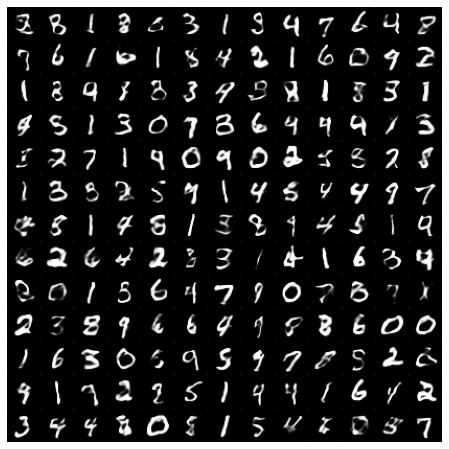

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

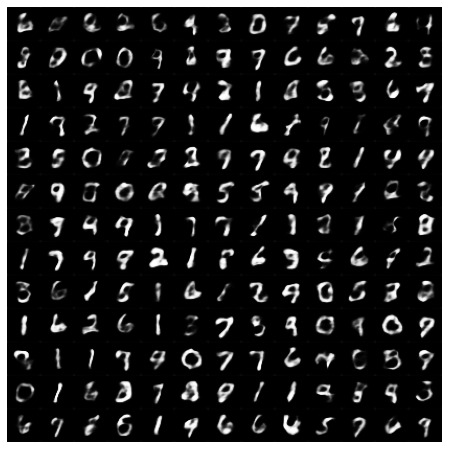

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

## Reconstruction + L2 [Weight: 1] ; 10 epochs, 5 Hierarchy Groups, 5 Latent per Group


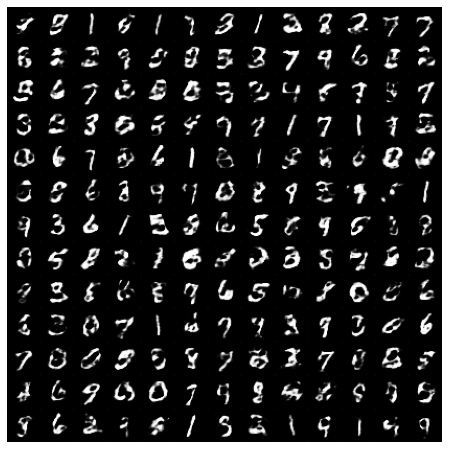

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

## Reconstruction + L2 [Weight: 1] ; 50 epochs, 5 Hierarchy Groups, 1 Latent per Group

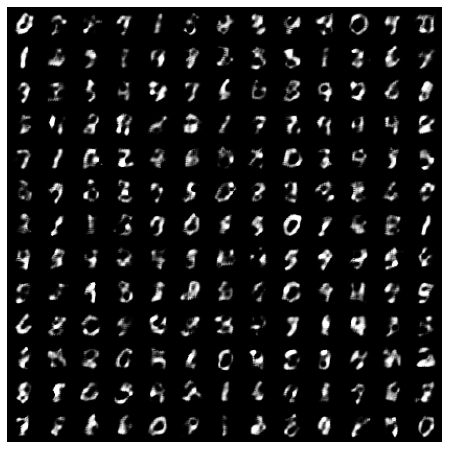

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

## Reconstruction + L2 [Weight: 1000] ; 4 epochs, 5 Hierarchy Groups

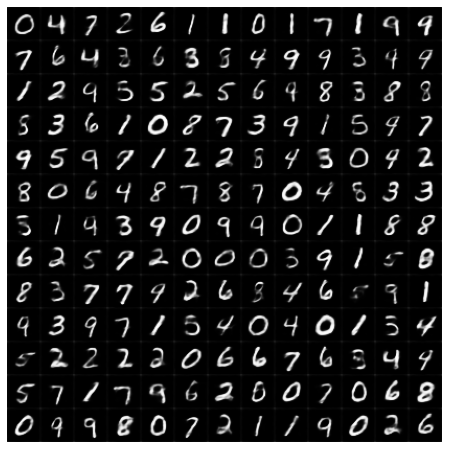

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

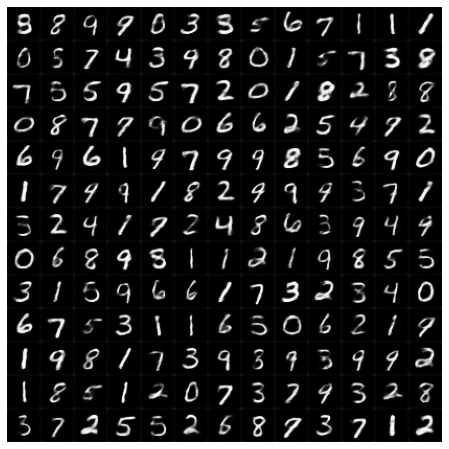

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

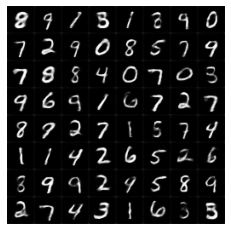

In [ ]:
num_samples = 64
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit, size=(4,4))

## Latent Space

In [ ]:
num_samples = 10000
# Get samples
xpde = gmm_drichlet.sample(num_samples)[0]
nrae = z_enc.cpu().detach()
# Concatenate
concat = np.concatenate([xpde, nrae])
# Fit TSNE
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(concat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


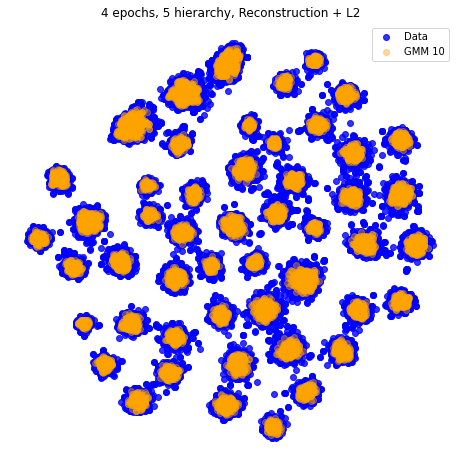

In [ ]:
# Number of samples to visualize
num_samples = 10000
# Figure properties
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.title('4 epochs, 5 hierarchy, Reconstruction + L2')
# Visualize
plt.scatter(latent[num_samples:, 0], latent[num_samples:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent[:num_samples, 0], latent[:num_samples, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

## Reconstruction + L2 [Weight: 50] + Embedding Loss [Weight: 1e-2] ; 4 epochs, 5 Hierarchy Groups

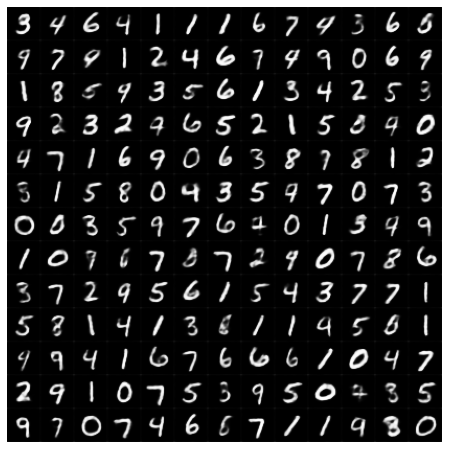

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

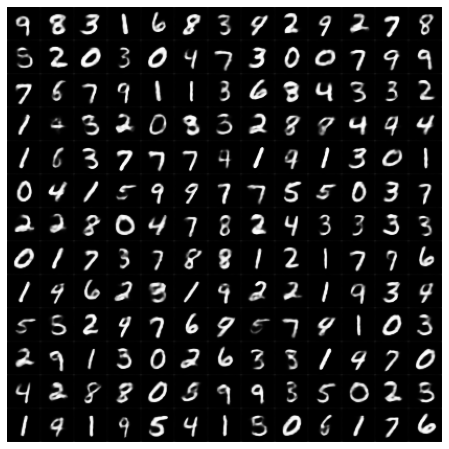

In [ ]:
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

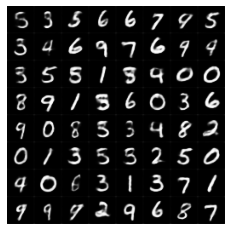

In [ ]:
num_samples = 64
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit, size=(4,4))

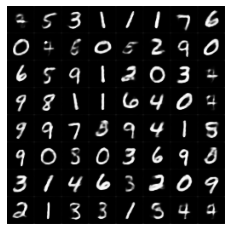

In [ ]:
num_samples = 64
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit, size=(4,4))

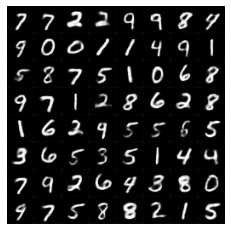

In [ ]:
num_samples = 64
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit, size=(4,4))

In [ ]:
num_samples = 10000
# Get samples
xpde = gmm_drichlet.sample(num_samples)[0]
nrae = z_enc.cpu().detach()
# Concatenate
concat = np.concatenate([xpde, nrae])
# Fit TSNE
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(concat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


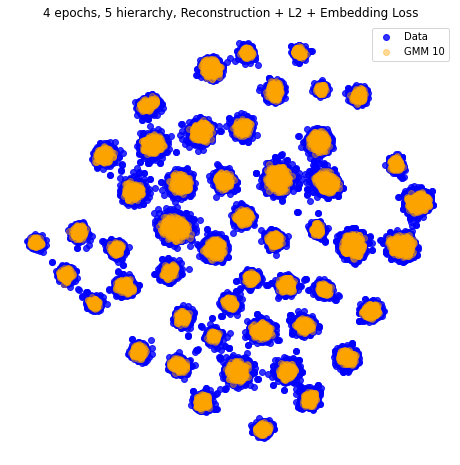

In [ ]:
# Number of samples to visualize
num_samples = 10000
# Figure properties
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.title('4 epochs, 5 hierarchy, Reconstruction + L2 + Embedding Loss')
# Visualize
plt.scatter(latent[num_samples:, 0], latent[num_samples:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent[:num_samples, 0], latent[:num_samples, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

## Meeting

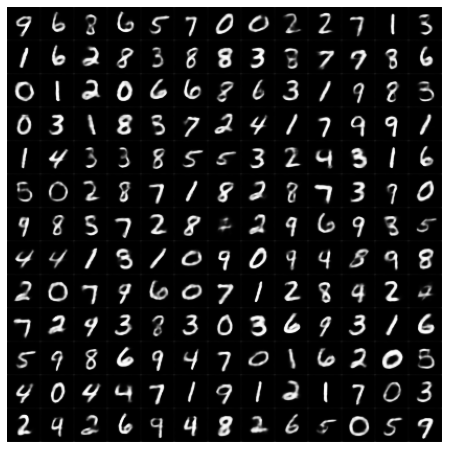

In [ ]:
# Drichlet
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm_drichlet, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

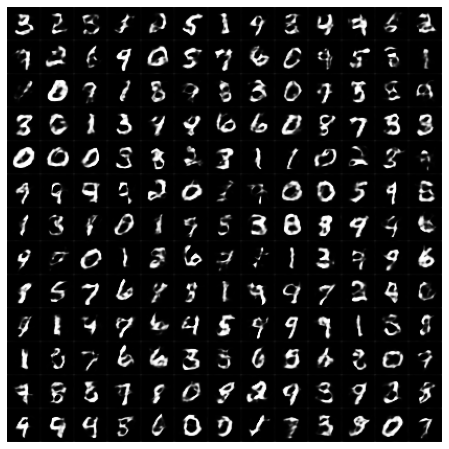

In [ ]:
# GMM-10
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

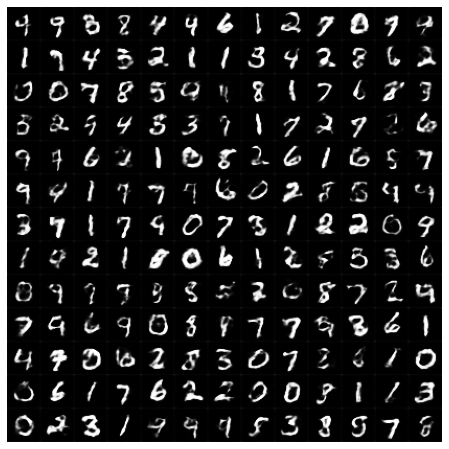

In [ ]:
# GMM-20
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

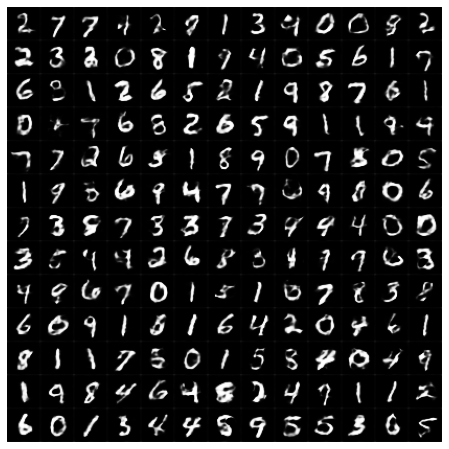

In [ ]:
# GMM-50
num_samples = 169
logit_nrae_sampled, _ = sample(model_nrae, gmm, num_samples, None)
idx = torch.randperm(num_samples)
logit = logit_nrae_sampled[idx]
visualize(num_samples, model_nrae, logit)

## Latent Space

In [ ]:
num_samples = 10000
# Get samples
xpde = gmm.sample(num_samples)[0]
nrae = z_enc[:num_samples].cpu().detach()
# Concatenate
concat = np.concatenate([xpde, nrae])
# Fit TSNE
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(concat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


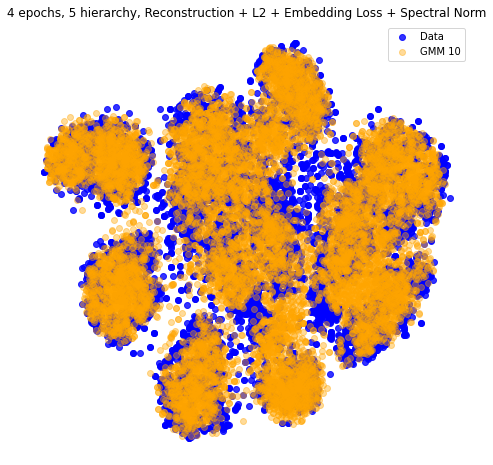

In [ ]:
# Number of samples to visualize
num_samples = 10000
# Figure properties
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.title('4 epochs, 5 hierarchy, Reconstruction + L2 + Embedding Loss + Spectral Norm')
# Visualize
plt.scatter(latent[num_samples:, 0], latent[num_samples:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent[:num_samples, 0], latent[:num_samples, 1], color='orange', alpha=0.4, label='GMM 10')
plt.legend();

In [ ]:
num_samples = 10000
# Get samples
xpde = gmm_drichlet.sample(num_samples)[0]
nrae = z_enc[:num_samples].cpu().detach()
# Concatenate
concat = np.concatenate([xpde, nrae])
# Fit TSNE
latent = TSNE(n_components=2, learning_rate='auto').fit_transform(concat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


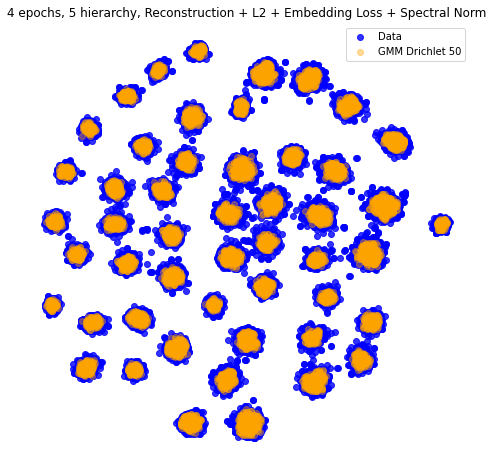

In [ ]:
# Number of samples to visualize
num_samples = 10000
# Figure properties
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
plt.title('4 epochs, 5 hierarchy, Reconstruction + L2 + Embedding Loss + Spectral Norm')
# Visualize
plt.scatter(latent[num_samples:, 0], latent[num_samples:, 1], color='blue',   alpha=0.8, label='Data')
plt.scatter(latent[:num_samples, 0], latent[:num_samples, 1], color='orange', alpha=0.4, label='GMM Drichlet 50')
plt.legend();

# FID Calculation

In [ ]:
from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3
import utils

In [ ]:
args_rae.fid_dir = 'fid_results'

In [ ]:
def create_generator_vae(model, batch_size, num_total_samples):
    num_iters = int(np.ceil(num_total_samples / batch_size))
    for i in range(num_iters):
        with torch.no_grad():
          output_img, _ = sample(model, gmm_drichlet, args_rae.batch_size, None)
        yield output_img.float()


def test_vae_fid(model, args, total_fid_samples):
    dims = 2048
    device = 'cuda'
    num_gpus = args.num_process_per_node * args.num_proc_node
    num_sample_per_gpu = int(np.ceil(total_fid_samples / num_gpus))

    g = create_generator_vae(model, args.batch_size, num_sample_per_gpu)
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx], model_dir=args.fid_dir).to(device)
    m, s = compute_statistics_of_generator(g, model, args.batch_size, dims, device, max_samples=num_sample_per_gpu)

    # share m and s
    m = torch.from_numpy(m).cuda()
    s = torch.from_numpy(s).cuda()
    # take average across gpus
    utils.average_tensor(m, args.distributed)
    utils.average_tensor(s, args.distributed)

    # convert m, s
    m = m.cpu().numpy()
    s = s.cpu().numpy()

    # load precomputed m, s
    path = os.path.join(args.fid_dir, args.dataset + '.npz')
    m0, s0 = load_statistics(path)

    fid = calculate_frechet_distance(m0, s0, m, s)
    return fid

In [ ]:
from scripts.precompute_fid_statistics import main
main(args_rae) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weigh

len train queue 300 len val queue 50 batch size 200


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to fid_results/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

AttributeError: ignored